In [1]:
import pandas as pd
import numpy as np
from datetime import date, datetime
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, KFold, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.impute import KNNImputer, SimpleImputer

import lightgbm as lgm
from xgboost import XGBClassifier

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from tabpfn import TabPFNClassifier

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers

from lofo import LOFOImportance, Dataset, plot_importance

import optuna

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lofo\lofo_importance.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def balanced_log_loss(y_true, y_pred):
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0))
    log_loss_1 = -np.sum(y_true * np.log(p_1))
    w_0 = 1 / N_0
    w_1 = 1 / N_1
    balanced_log_loss = 2*(w_0 * log_loss_0 + w_1 * log_loss_1) / (w_0 + w_1)
    return balanced_log_loss/(N_0+N_1)

def lgb_metric(y_true, y_pred):
    return 'balanced_log_loss', balanced_log_loss(y_true, y_pred), False

In [73]:
def competition_log_loss(y_true, y_pred):
    # y_true: correct labels 0, 1
    # y_pred: predicted probabilities of class=1
    # Implements the Evaluation equation with w_0 = w_1 = 1.
    # Calculate the number of observations for each class
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    # Calculate the predicted probabilities for each class
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    # Calculate the average log loss for each class
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0)) / N_0
    log_loss_1 = -np.sum(y_true * np.log(p_1)) / N_1
    # return the (not further weighted) average of the averages
    return (log_loss_0 + log_loss_1)/2

In [4]:
train_df = pd.read_csv('train.csv')
greek_df = pd.read_csv('greeks.csv')
test_df = pd.read_csv('test.csv')

train_df.columns = [col.strip() for col in train_df.columns]
train_df['EJ'] = train_df['EJ'].map({'B' : 0, 'A':1})

test_df.columns = [col.strip() for col in test_df.columns]
test_df['EJ'] = test_df['EJ'].map({'B': 0, 'A' : 1})

In [5]:
int_denominators = {
 'AB': 0.004273,
 'AF': 0.00242,
 'AH': 0.008709,
 'AM': 0.003097,
 'AR': 0.005244,
 'AX': 0.008859,
 'AY': 0.000609,
 'AZ': 0.006302,
 'BC': 0.007028,
 'BD': 0.00799,
 'BN': 0.3531,
 'BP': 0.004239,
 'BQ': 0.002605,
 'BR': 0.006049,
 'BZ': 0.004267,
 'CB': 0.009191,
 'CC': 6.12e-06,
 'CD': 0.007928,
 'CF': 0.003041,
 'CH': 0.000398,
 'CL': 0.006365,
 'CR': 7.5e-05,
 'CS': 0.003487,
 'CU': 0.005517,
 'CW': 9.2e-05,
 'DA': 0.00388,
 'DE': 0.004435,
 'DF': 0.000351,
 'DH': 0.002733,
 'DI': 0.003765,
 'DL': 0.00212,
 'DN': 0.003412,
 'DU': 0.0013794,
 'DV': 0.00259,
 'DY': 0.004492,
 'EB': 0.007068,
 'EE': 0.004031,
 'EG': 0.006025,
 'EH': 0.006084,
 'EL': 0.000429,
 'EP': 0.009269,
 'EU': 0.005064,
 'FC': 0.005712,
 'FD': 0.005937,
 'FE': 0.007486,
 'FI': 0.005513,
 'FR': 0.00058,
 'FS': 0.006773,
 'GB': 0.009302,
 'GE': 0.004417,
 'GF': 0.004374,
 'GH': 0.003721,
 'GI': 0.002572
}
for k, v in int_denominators.items():
    train_df[k] = np.round(train_df[k]/v,1)

In [6]:
train_df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,49.0,1284724.5,9783.0,7231.0,1552.0,79.0,42.0,1557.0,790.5,...,7.298162,2997.5,14.0,1219.0,16439.0,458118.5,5949.0,27152.0,0.120343,1
1,007255e47698,34.0,404448.0,9783.0,11937.0,1552.0,410.0,42.0,2145.0,175.0,...,0.173229,857.0,84.0,999.0,16439.0,6397248.0,7830.0,12493.0,21.978000,0
2,013f2bd269f5,110.0,1088887.0,9783.0,10449.0,1552.0,760.0,42.0,2035.0,175.0,...,7.709560,1682.0,177.0,3986.0,20061.0,3126876.5,7531.0,13683.0,0.196941,0
3,043ac50845d5,59.0,1578368.5,13802.0,24899.0,1552.0,416.0,42.0,1754.0,175.0,...,6.122162,857.0,42.0,1992.0,18659.0,478798.0,10736.0,35184.0,0.155829,0
4,044fb8a146ec,89.0,1542582.0,9783.0,4554.0,1552.0,445.0,90.0,539.0,14535.0,...,8.153058,83623.0,18.0,1764.0,33079.0,1948873.0,12196.0,14099.0,0.096614,1


In [7]:
greek_df.head()

,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown
2,013f2bd269f5,A,C,M,B,Unknown
3,043ac50845d5,A,C,M,B,Unknown
4,044fb8a146ec,D,B,F,B,3/25/2020


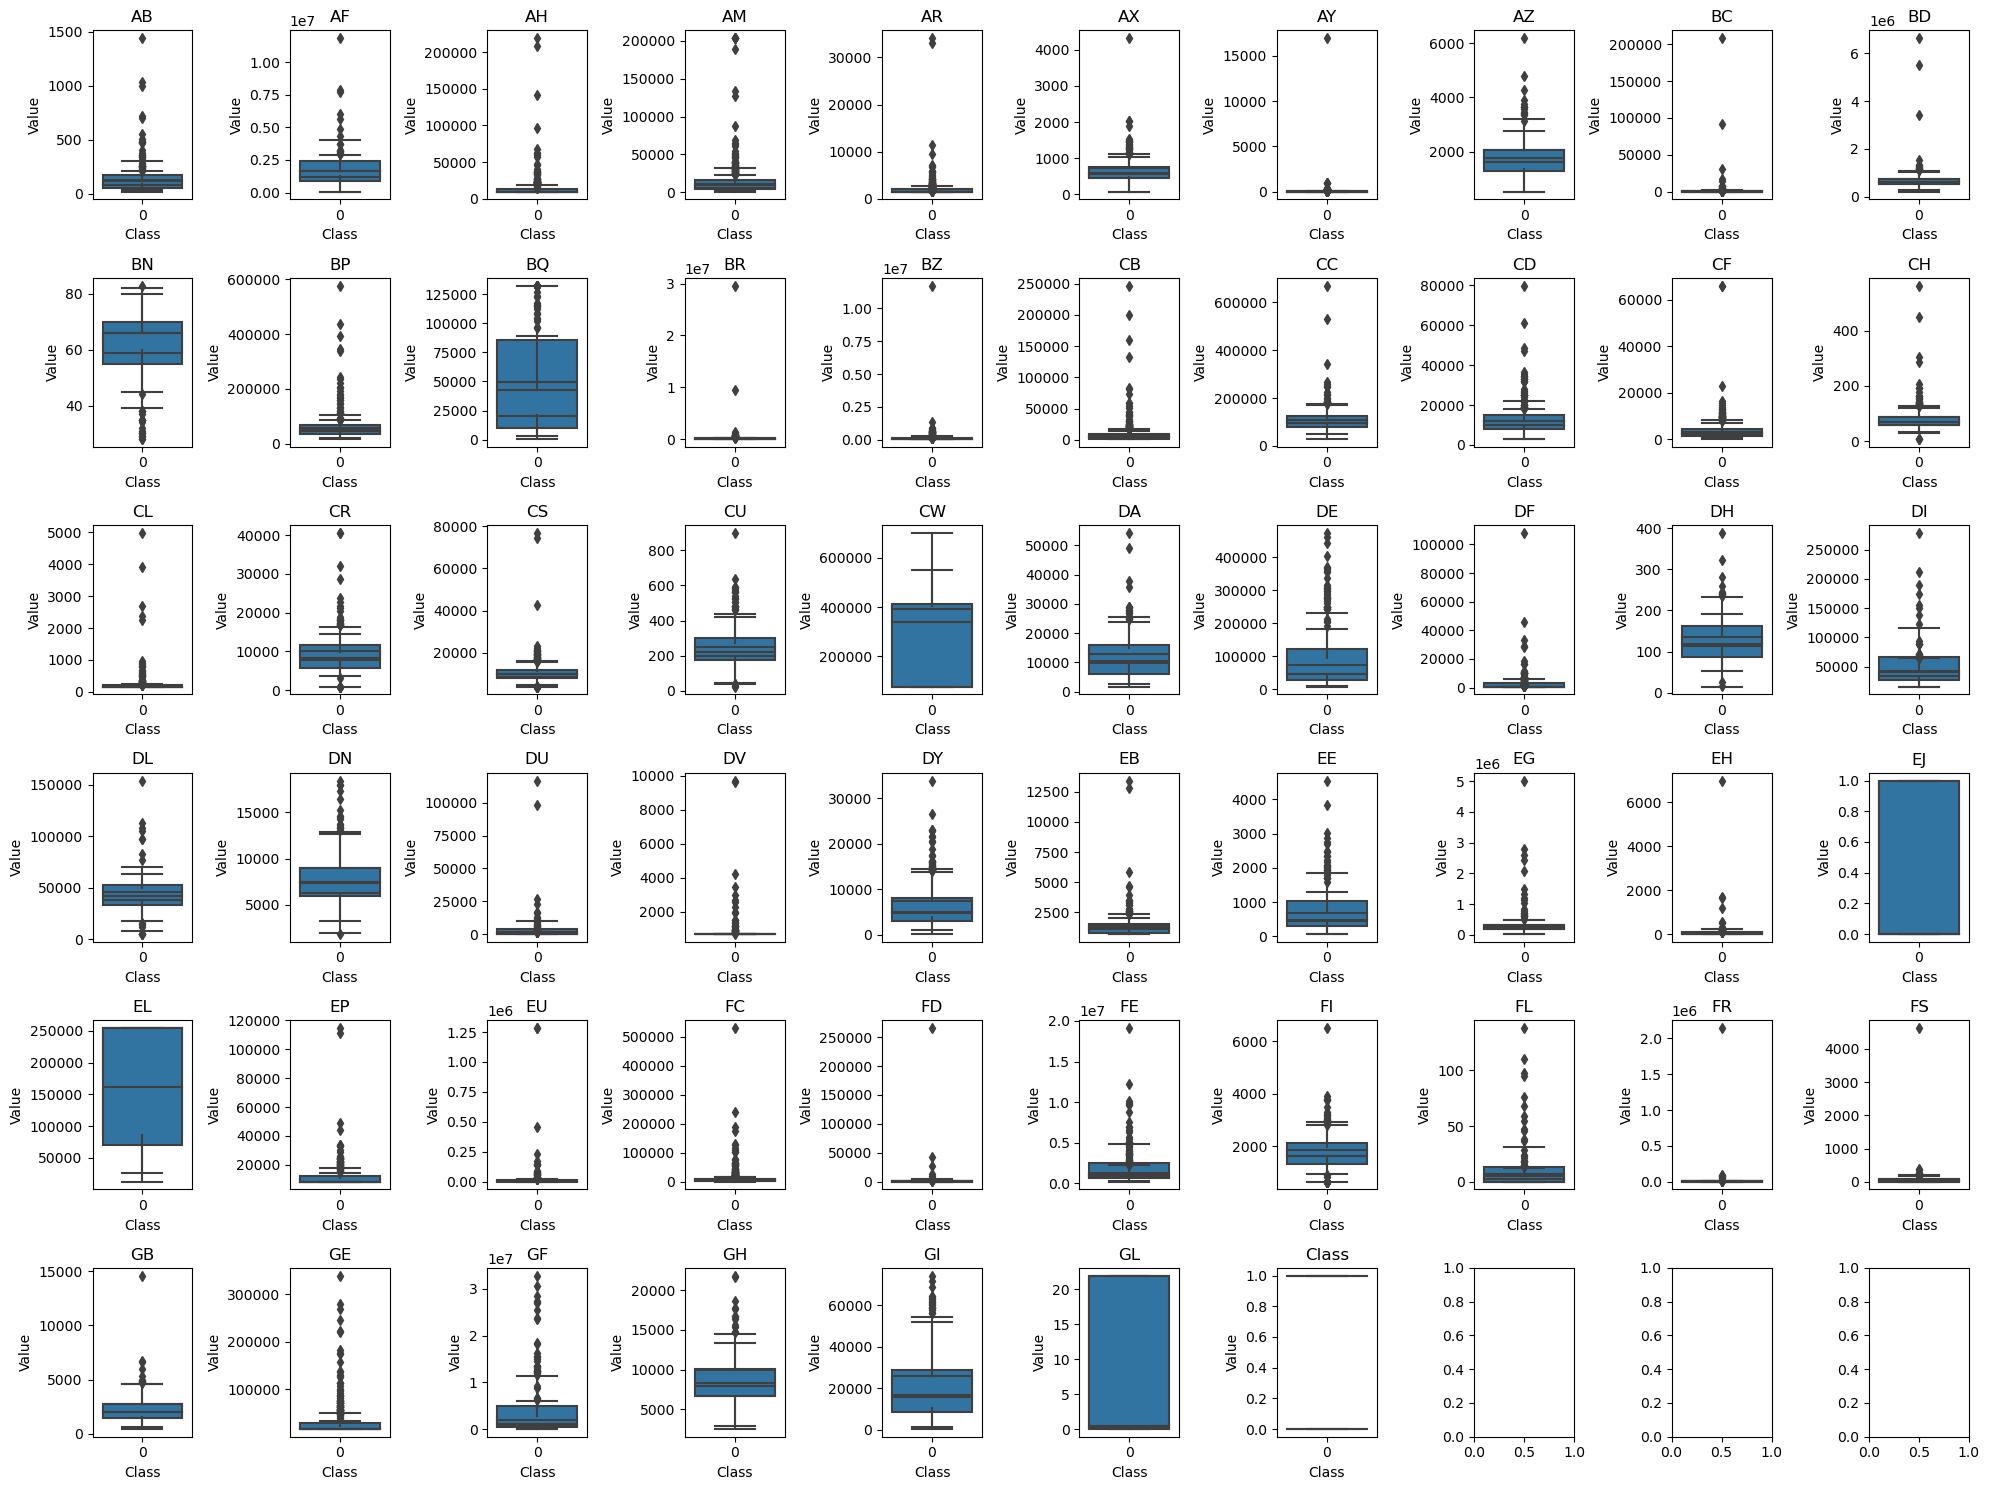

In [102]:
# Select the columns for plotting
columns_to_plot = train_df.select_dtypes('number').columns[:57]

# Set up the grid for subplots
fig, axes = plt.subplots(6, 10, figsize=(20, 15))

# Iterate over the columns and plot box plots for each column
for i, column in enumerate(columns_to_plot):
    # Calculate the row and column indices for subplot
    row = i // 10
    col = i % 10
    
    # Plot box plots for each class separately
    for cls in train_df['Class'].unique():
        # Filter the data for the current class
        data = train_df[train_df['Class'] == cls]
        
        # Plot the box plot
        sns.boxplot(data=data, x='Class', y=column, ax=axes[row, col])
    
    # Set the title and labels for the subplot
    axes[row, col].set_title(column)
    axes[row, col].set_xlabel('Class')
    axes[row, col].set_ylabel('Value')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [8]:
class WeightedEns(BaseEstimator):
    def __init__(self):
        self.param_grid = {'learning_rate': 0.07103098041575105,
                           'num_iterations': 504,
                           'num_leaves': 50,
                           'max_depth': 3,
                           'min_data_leaf': 52}
        self.classifiers = [lgm.LGBMClassifier(**self.param_grid, class_weight='balanced'),TabPFNClassifier(N_ensemble_configurations=64)]
        self.imp = SimpleImputer(missing_values=np.nan, strategy='median')
    
    def fit(self, X, y):
        cls, y = np.unique(y, return_inverse=True)
        self.classes_ = cls
        X = self.imp.fit_transform(X)
        for cl in self.classifiers:
            cl.fit(X,y)
    
    def predict_proba(self, X):
        X = self.imp.transform(X)
        ps = np.stack([cl.predict_proba(X) for cl in self.classifiers])
        p = np.mean(ps,axis=0)
        class_0_est_instances = p[:,0].sum()
        others_est_instances = p[:,1:].sum()
        
        # reweighting the predictions for balanced log loss
        new_p = p * np.array([[1/(class_0_est_instances if i==0 else others_est_instances) for i in range(p.shape[1])]])
        return new_p / np.sum(new_p,axis=1,keepdims=1)

In [10]:
def objective(trial):

    skf = KFold(n_splits=10)
    
    param_grid = {
        'boosting_type' : 'goss',
        'learning_rate' : trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        'num_estimators' : 5000,
        'early_stopping_rounds' : 200,
        'num_leaves' : trial.suggest_int('num_leaves', 35, 128),
        'max_depth' : trial.suggest_int('max_depth', 2, 16),
        'lambda_l1':trial.suggest_float('lambda_l1', 1e-1, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 0.75),
        'colsample_bytree':trial.suggest_float('colsample_bytree', 0.5, 0.8),
        'is_unbalance' : False,
        'metric' : None,
        'class_weight' : 'balanced'
    }

    X = train_df.copy()
    y = train_df['Class'].values

    oof = pd.DataFrame({'id' : X['Id'].values, 'pred' : 1}).set_index('id')
#     tab_oof = pd.DataFrame({'id' : X['Id'].values, 'pred' : 1}).set_index('id')

    for i, (train, val) in enumerate(skf.split(X, y)):

        train_x = X.iloc[train].drop(columns=['Id', 'Class']).copy()
        train_y = y[train]

#         train_x = X_scaled[train]
#         train_y = y[train]

        # getting the id values
        id_val = X.iloc[val]['Id']
        val_x = X.iloc[val].drop(columns=['Id', 'Class']).copy()
#         val_x = X_scaled[val]
        val_y = y[val]

        model = lgm.LGBMClassifier(**param_grid)
        model.fit(train_x, train_y, eval_set=[(val_x, val_y)], eval_metric=lgb_metric, verbose=False)    

#         weighted_model = WeightedEns(param_grid=param_grid)
#         weighted_model.fit(train_x, train_y)

        preds = model.predict_proba(val_x)[:,1]
#         weighted_preds = weighted_ensemble.predict_proba(val_x)[:,0]
        
#         tab_model = TabPFNClassifier()
#         tab_train_y = greek_df['Alpha'].values[train]
        
#         tab_model.fit(train_x, tab_train_y)
        
#         tab_preds = 1 - tab_model.predict_proba(val_x)[:,0]
        

        oof.loc[id_val, 'pred'] = preds
#         tab_oof.loc[id_val, 'pred'] = tab_preds

    id_class_dict = train_df.set_index('Id')['Class'].to_dict()
    oof['class'] = oof.index.map(id_class_dict)
    
#     blended_preds = (oof['pred'] + tab_oof['pred']) / 2

    return competition_log_loss(oof['class'], oof['pred'])

In [11]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=900, timeout=1500)

[I 2023-05-30 10:38:10,827] A new study created in memory with name: no-name-3a06603b-f373-48b9-a49a-d27ee8a3e732
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of Li

[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.21272316573704805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21272316573704805
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.21272316573704805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21272316573704805
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.21272316573704805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21272316573704805
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200


C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is d

[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.21272316573704805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21272316573704805
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.21272316573704805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21272316573704805
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.21272316573704805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21272316573704805
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is d

[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.21272316573704805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21272316573704805
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.21272316573704805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21272316573704805
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.21272316573704805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21272316573704805
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200


C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.7631893523205666, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7631893523205666
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.7631893523205666, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7631893523205666
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.7631893523205666, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7631893523205666
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200


C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is d

[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.7631893523205666, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7631893523205666
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.7631893523205666, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7631893523205666
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.7631893523205666, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7631893523205666
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200


C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is d

[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.7631893523205666, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7631893523205666
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.7631893523205666, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7631893523205666
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.7631893523205666, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7631893523205666
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200


C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-05-30 10:38:12,281] Trial 1 finished with value: 0.6206427534693936 and parameters: {'learning_rate': 0.0017341674778506145, 'num_leaves': 87, 'max_depth': 13, 'lambda_l1': 0.7631893523205666, 'subsample': 0.6930796519193625, 'colsample_bytree': 0.5313544674552603}. Best is trial 0 with value: 0.5860532090596458.
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in

[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.7631893523205666, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7631893523205666
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.9272393993696115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9272393993696115
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.9272393993696115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9272393993696115
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unkn

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is d

[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.9272393993696115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9272393993696115
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.9272393993696115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9272393993696115
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.9272393993696115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9272393993696115
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unkn

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is d

[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.9272393993696115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9272393993696115
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.9272393993696115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9272393993696115
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.9272393993696115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9272393993696115
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200


[I 2023-05-30 10:38:12,982] Trial 2 finished with value: 0.6170799116817604 and parameters: {'learning_rate': 0.0018066945381821353, 'num_leaves': 66, 'max_depth': 14, 'lambda_l1': 0.9272393993696115, 'subsample': 0.7052543295453045, 'colsample_bytree': 0.5955330274947568}. Best is trial 0 with value: 0.5860532090596458.
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in

[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.9194978465731236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9194978465731236
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.9194978465731236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9194978465731236
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.9194978465731236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9194978465731236
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200


C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is d

[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.9194978465731236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9194978465731236
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.9194978465731236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9194978465731236
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.9194978465731236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9194978465731236
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unkn

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is d

[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.9194978465731236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9194978465731236
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.9194978465731236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9194978465731236
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.9194978465731236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9194978465731236
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200


C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is d

[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.32669331843471494, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.32669331843471494
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.32669331843471494, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.32669331843471494
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.32669331843471494, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.32669331843471494
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200


C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is d

[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.32669331843471494, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.32669331843471494
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.32669331843471494, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.32669331843471494
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.32669331843471494, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.32669331843471494
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is d

[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.32669331843471494, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.32669331843471494
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.32669331843471494, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.32669331843471494
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.32669331843471494, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.32669331843471494
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200


C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is d

[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.12924795711304568, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12924795711304568
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.12924795711304568, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12924795711304568
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.12924795711304568, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12924795711304568
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is d

[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.12924795711304568, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12924795711304568
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.12924795711304568, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12924795711304568
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.12924795711304568, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12924795711304568
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-05-30 10:38:15,128] Trial 5 finished with value: 0.27382017645910767 and parameters: {'learning_rate': 0.03784347447403465, 'num_leaves': 41, 'max_depth': 12, 'lambda_l1': 0.12924795711304568, 'subsample': 0.6437675557713239, 'colsample_bytree': 0.6224091993675578}. Best is trial 4

[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.12924795711304568, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12924795711304568
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.12924795711304568, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12924795711304568
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.13252032595349683, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13252032595349683
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[W 2023-05-30 10:38:15,313] Trial 6 failed with parameters: {'learning_rate': 0.00276351097545748, 'num_leaves': 55, 'max_depth': 3, 'lambda_l1': 0.13252032595349683, 'subsample': 0.5256937298950015, 'colsample_bytree': 0.7860267184705482} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\yaobv\AppData\Local\Temp\ipykernel_16220\3888900783.py", line 41, in objective
    model.fit(train_x, train_y, eval_set=[(val_x, val_y)], eval_met

[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] lambda_l1 is set=0.13252032595349683, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13252032595349683
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200


KeyboardInterrupt: 

In [ ]:

plot_param_importances(study)

In [87]:
train_df.shape

(617, 58)

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is d

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is d

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is d

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is d

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is d

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is d

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is d

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is d

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is d

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is d

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is d

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is d

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is d

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is d

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is d

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is d

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is d

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is d

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is d

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is d

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is d

0.1032429829231444


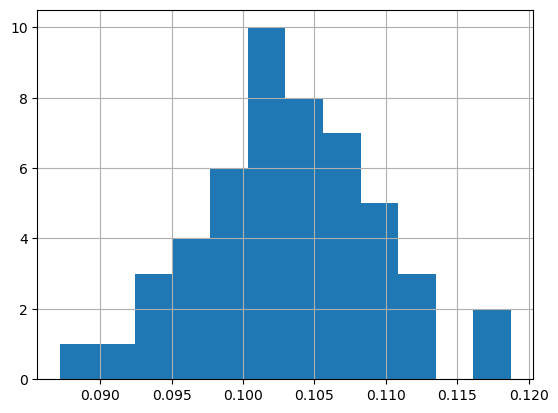

In [77]:
scores = []

for n in range(50):

    skf = StratifiedKFold(n_splits=10, shuffle=True)

    X = train_df.drop(columns=['AF', 'FL', 'EJ', 'FE']).copy()
    y = train_df['Class'].values

    models = {}
    oof = np.zeros(len(X))

    # oof = pd.DataFrame({'id' : X['Id'].values, 'pred' : 1}).set_index('id')

    for i, (train, val) in enumerate(skf.split(X, y)):

        train_x = X.iloc[train].drop(columns=['Id', 'Class']).copy()
        train_y = y[train]

        POS_CLASS = train_y.sum()    
        undersampler = RandomUnderSampler(sampling_strategy={0: POS_CLASS, 1: POS_CLASS})
        resampled_x, resampled_y = undersampler.fit_resample(train_x, train_y)

        # getting the id values
        id_val = X.iloc[val]['Id']
        val_x = X.iloc[val].drop(columns=['Id', 'Class']).copy()
        val_y = y[val]

        model = lgm.LGBMClassifier(boosting_type='goss',
                                   learning_rate=0.06733232950390658,
                                   n_estimators = 50000, 
                                   early_stopping_round = 300,
                                   random_state=42,
                                   subsample=0.6970532011679706,
                                   colsample_bytree=0.6055755840633003,
                                   max_depth=8,
                                   class_weight='balanced',
                                   metric='none', 
                                   is_unbalance=True)

        model.fit(train_x, train_y, eval_set=[(val_x, val_y)], eval_metric=lgb_metric, verbose=False)

        preds = model.predict_proba(val_x)[:,1]

    #     oof.loc[id_val, 'pred'] = preds
        oof[val] = preds

        models[f'model_{i}'] = model

    # id_class_dict = train_df.set_index('Id')['Class'].to_dict()
    # oof['class'] = oof.index.map(id_class_dict)
    scores.append(balanced_log_loss(y, oof))

print(np.mean(scores))

pd.Series(scores).hist(bins=12)
plt.show()

In [52]:
competition_log_loss(y, oof)

0.16421502283712963

In [72]:
balanced_log_loss(y, oof)

0.10915495991456987

In [ ]:
model = lgm.LGBMClassifier(boosting_type='goss',
                       learning_rate=0.06733232950390658,
                       n_estimators = 50000, 
                       early_stopping_round = 300,
                       random_state=42,
                       subsample=0.6970532011679706,
                       colsample_bytree=0.6055755840633003,
                       max_depth=8,
                       class_weight='balanced',
                       metric='none', 
                       is_unbalance=True)

model.fit(train_x, train_y, eval_set=[(val_x, val_y)], eval_metric=lgb_metric, early_stopping_rounds=35)

In [23]:
fi_df = train_df.drop(columns=['Id']).copy()

cv = StratifiedKFold(n_splits=10, shuffle=False, random_state=None)
data = Dataset(df=fi_df, target="Class", features=[col for col in fi_df.columns if col not in ['Class', 'AF', 'FL', 'EJ', 'FE']])

model = lgm.LGBMClassifier(boosting_type='goss',
                           learning_rate=0.06733232950390658,
                           n_estimators = 888,
                           random_state=42,
                           subsample=0.6970532011679706,
                           colsample_bytree=0.6055755840633003,
                           max_depth=8,
                           class_weight='balanced')

lofo_imp = LOFOImportance(data, cv=cv, scoring='neg_log_loss', model=model)
importance_df = lofo_imp.get_importance()

  0%|          | 0/52 [00:00<?, ?it/s]

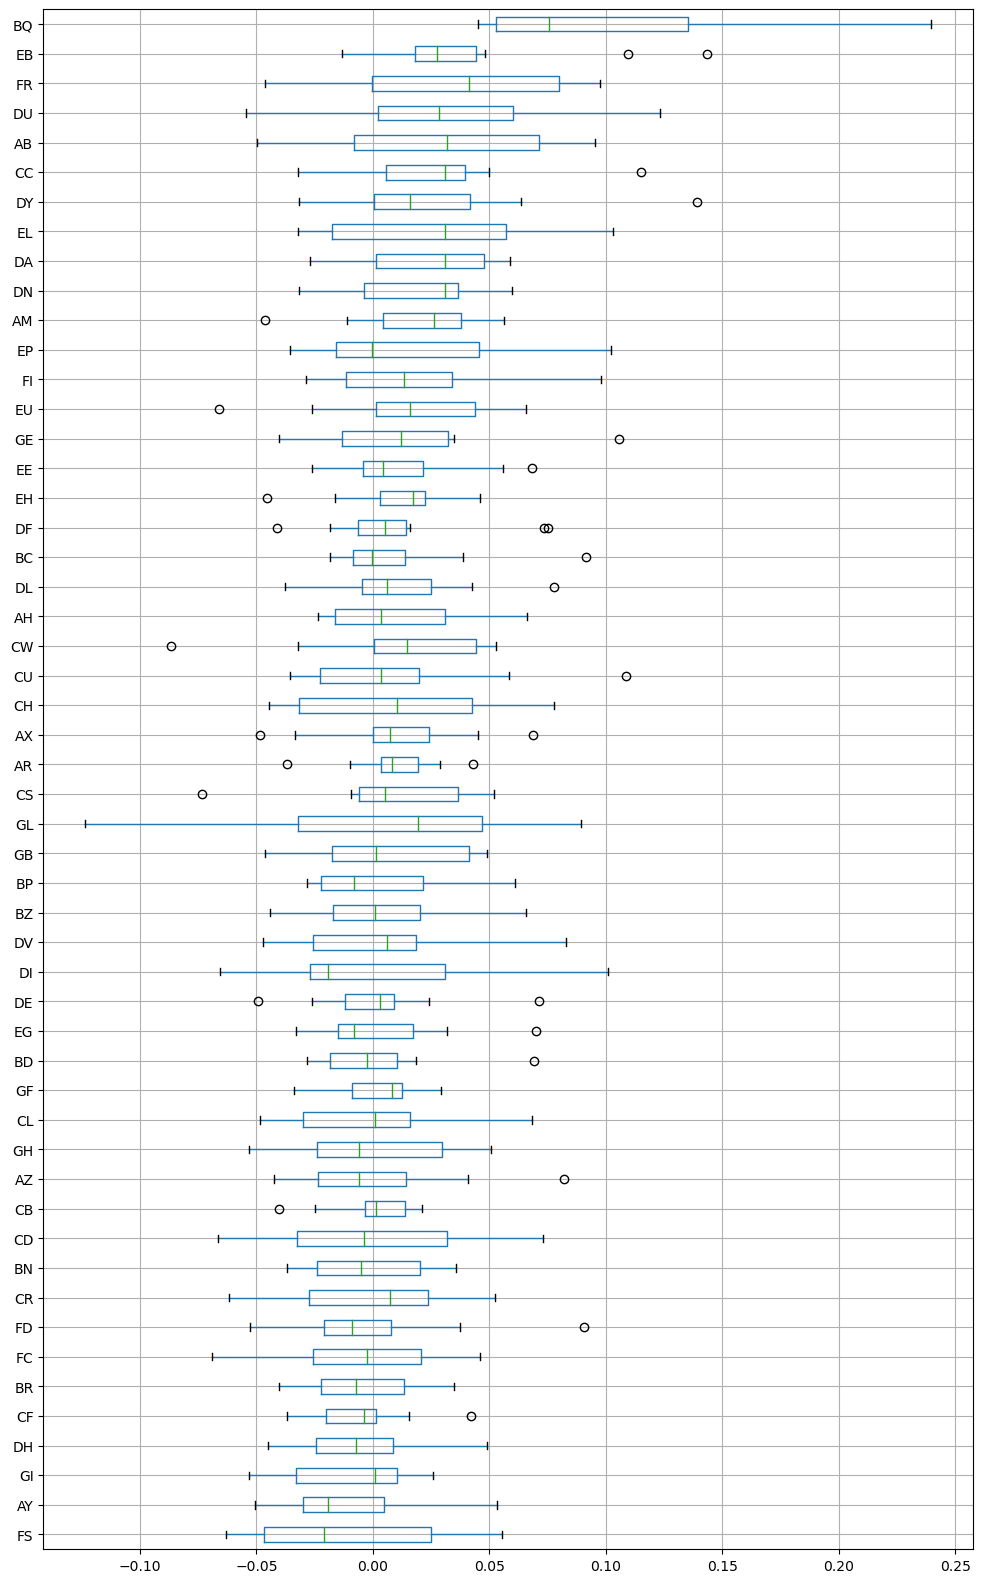

In [25]:
plot_importance(importance_df, figsize=(12, 20), kind='box')

In [97]:
test_preds = pd.DataFrame()

for model in models.keys():
    features = models[model].feature_name_
    p = models[model].predict_proba(test_df[features])[:,1]
    test_preds = pd.concat([test_preds, pd.Series(p)], axis=1)

test_preds.mean(axis=1)

0    0.453747
1    0.453747
2    0.453747
3    0.453747
4    0.453747
dtype: float64